In [13]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import HPVnetwork as HPVN
import warnings
import seaborn as sns
import gurobipy as gp
from gurobipy import GRB
import pickle
import os
from gurobipy import Env, GRB
from collections import deque
from numpy import linalg as LA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats
import random
import matplotlib.pyplot as plt


### Import networks and solutions

In [2]:
file_path = 'Data/hpvdata.csv'
hpvdata = pd.read_csv(file_path)
hpvdata = hpvdata.dropna(subset=['HPV_VAX_attitu_s35'])
Network = []
Opt_Solutions = []
for i in range(60):
    with open("100_Network_Samples/network"+str(i)+".pkl", "rb") as file:
        Network.append(pickle.load(file))
    with open("100_Network_Sols/sol_50_network"+str(i)+".pkl", "rb") as file:
        Opt_Solutions.append(pickle.load(file))

/var/folders/b3/kkdtnh4d4gjgrk45d_yrf4100000gn/T/ipykernel_13167/148312007.py:2: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  hpvdata = pd.read_csv(file_path)


## Compute the number of positives

In [3]:
with open("Results_section/num_pos_optimization.pkl", "rb") as file:
    num_pos_optimization = pickle.load(file)

In [4]:
# generate random solutions
random_sol = []
for i in range(60):
    candidates = []
    for j in Network[i].G.nodes:
        if Network[i].G.nodes.data('initial attitude')[j]>=12:
            candidates.append(j)
    random_sol.append(random.sample(candidates, 50))

In [5]:
with open("Results_section/num_pos_random.pkl", "rb") as file:
    num_pos_random = pickle.load(file)

In [6]:
# Generate the solutions using most contacts
contact_sol = []
for i in range(60):
    candidates = {}
    for j in Network[i].G.nodes:
        if Network[i].G.nodes.data('initial attitude')[j]>=12:
            candidates[j]=Network[i].G.degree[j]
    contact_sol.append(list(sorted(candidates, key=candidates.get, reverse=True)[:50]))


In [7]:
with open("Results_section/num_pos_contact.pkl", "rb") as file:
    num_pos_contact = pickle.load(file)

In [8]:
diff1 = [num_pos_optimization[i]-num_pos_random[i] for i in range(60)]
diff2 = [num_pos_optimization[i]-num_pos_contact[i] for i in range(60)]

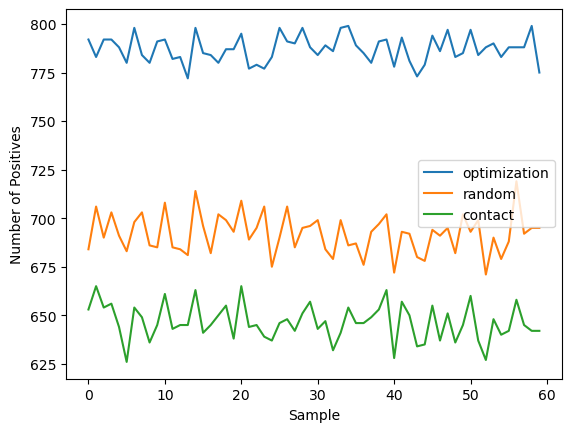

In [42]:
plt.plot(num_pos_optimization,label='optimization')
plt.plot(num_pos_random,label='random')
plt.plot(num_pos_contact,label='contact')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Number of Positives')
plt.show()

### Who do we select?

In [16]:
def ttest(str_name,sol_file):
    var_ = [i for i in hpvdata[str_name].values]
    with open(sol_file, "rb") as file:
        soluniform = pickle.load(file)
    selected = []
    unselected =[]
    for i in range(len(var_)):
        if i in soluniform:
            if var_[i]>0:
                selected.append(var_[i])
        else:
            if var_[i]>0:
                unselected.append(var_[i])
    #print(str_name)
    test = stats.ttest_ind(selected, unselected)
    if test.pvalue<0.01:
        print(stats.ttest_ind(selected, unselected))
        print(np.mean(selected))
        print(np.mean(unselected))
for i in range(60):
    ttest('HPV_VAX_attitu_s35',"100_Network_Sols/sol_50_network"+str(i)+".pkl")

Ttest_indResult(statistic=7.74895886413574, pvalue=2.207531903156525e-14)
20.44
13.694416243654823
Ttest_indResult(statistic=7.392671571331474, pvalue=2.9679990334480073e-13)
20.16
13.708629441624366
Ttest_indResult(statistic=7.46879745350993, pvalue=1.7186434040923752e-13)
20.22
13.705583756345177
Ttest_indResult(statistic=6.863013274129655, pvalue=1.16070448953125e-11)
19.74
13.72994923857868
Ttest_indResult(statistic=9.976397409318281, pvalue=1.9276081818725371e-22)
22.14
13.608121827411168
Ttest_indResult(statistic=7.29135367492017, pvalue=6.09529566478834e-13)
20.08
13.712690355329949
Ttest_indResult(statistic=8.236872466815736, pvalue=5.305733696807704e-16)
20.82
13.6751269035533
Ttest_indResult(statistic=6.687660557088981, pvalue=3.707302384583055e-11)
19.6
13.737055837563451
Ttest_indResult(statistic=7.266056570592171, pvalue=7.285240569669132e-13)
20.06
13.713705583756346
Ttest_indResult(statistic=7.16499602892264, pvalue=1.4774568333095497e-12)
19.98
13.717766497461929
Ttest_

### budget vs. # pos

In [24]:
with open("Results_section/obj_optimization_base_varying_budget.pkl", "rb") as file:
    base_obj_optimization = pickle.load(file)

In [31]:
with open("Results_section/obj_random_base_varying_budget.pkl", "rb") as file:
    base_obj_random = pickle.load(file)

In [35]:
with open("Results_section/obj_contact_base_varying_budget.pkl", "rb") as file:
    base_obj_contact = pickle.load(file)

Text(0.5, 0, 'Budget')

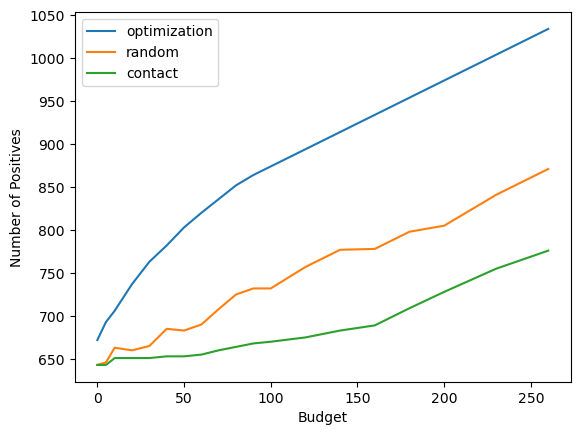

In [38]:
plt.plot(budgets[:-3],obj[:-3],label='optimization')
plt.plot(budgets[:-3],base_obj_random[:-3],label='random')
plt.plot(budgets[:-3],base_obj_contact[:-3],label='contact')
plt.legend()
plt.ylabel('Number of Positives')
plt.xlabel('Budget')